![](https://www.modernheartandvascular.com/wp-content/uploads/2022/10/HEart-failure.png)

image from [link](https://www.modernheartandvascular.com/congestive-heart-failure/)

### Dataset Details

Age: age of the patient (years)

Sex: sex of the patient (M: Male, F: Female)

ChestPainType: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)

RestingBP: resting blood pressure (mm Hg)

Cholesterol: serum cholesterol (mm/dl)

FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)

RestingECG: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)

MaxHR: maximum heart rate achieved (Numeric value between 60 and 202)

ExerciseAngina: exercise-induced angina (Y: Yes, N: No)

Oldpeak: oldpeak = ST (Numeric value measured in depression)

ST_Slope: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)

HeartDisease: output class (1: heart disease, 0: Normal)

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import LocalOutlierFactor  
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)   
pd.set_option('display.max_rows', None)    
pd.set_option('display.float_format', lambda x: '%.3f' % x)   
pd.set_option('display.width', 500) 

df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv") 

In [34]:
def check_df(dataframe, head=5):
    print("#################### Head ####################")
    print(dataframe.head(head))
    print("################### Shape ####################")
    print(dataframe.shape)
    print("#################### Info #####################")
    print(dataframe.info())
    print("################### Nunique ###################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("################## Quantiles #################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("################# Duplicated ###################")
    print(dataframe.duplicated().sum())

check_df(df)

#################### Head ####################
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
0   40   M           ATA        140          289          0     Normal    172              N    0.000       Up             0
1   49   F           NAP        160          180          0     Normal    156              N    1.000     Flat             1
2   37   M           ATA        130          283          0         ST     98              N    0.000       Up             0
3   48   F           ASY        138          214          0     Normal    108              Y    1.500     Flat             1
4   54   M           NAP        150          195          0     Normal    122              N    0.000       Up             0
################### Shape ####################
(918, 12)
#################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 col

In [35]:
# We need to identify the numerical and categorical variables in the data.

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    return cat_cols, num_cols, cat_but_car 

cat_cols, num_cols, cat_but_car = grab_col_names(df)

print(num_cols)
print(cat_cols)

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS', 'HeartDisease']


In [36]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        fig = plt.subplots(figsize=(6, 4))
        sns.distplot(df[col_name],
             kde=False,
             kde_kws={"color": "g", "alpha": 0.3, "linewidth": 5, "shade": True})
        plt.show(block=True)

count   918.000
mean     53.511
std       9.433
min      28.000
5%       37.000
10%      40.000
20%      45.000
30%      49.000
40%      52.000
50%      54.000
60%      57.000
70%      59.000
80%      62.000
90%      65.000
95%      68.000
99%      74.000
max      77.000
Name: Age, dtype: float64


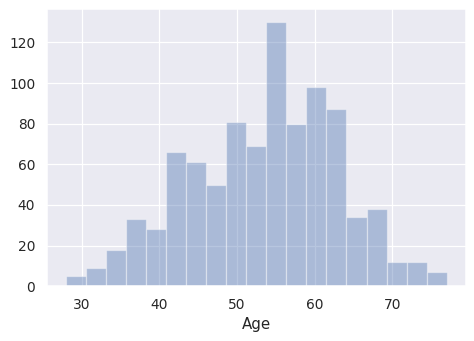

count   918.000
mean    132.397
std      18.514
min       0.000
5%      106.000
10%     110.000
20%     120.000
30%     120.000
40%     128.000
50%     130.000
60%     135.200
70%     140.000
80%     145.000
90%     160.000
95%     160.000
99%     180.000
max     200.000
Name: RestingBP, dtype: float64


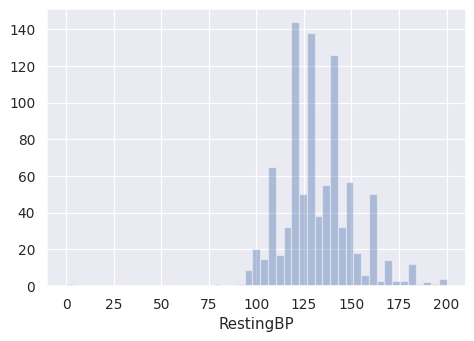

count   918.000
mean    198.800
std     109.384
min       0.000
5%        0.000
10%       0.000
20%     134.800
30%     190.000
40%     209.000
50%     223.000
60%     238.200
70%     257.000
80%     276.000
90%     305.000
95%     331.300
99%     411.490
max     603.000
Name: Cholesterol, dtype: float64


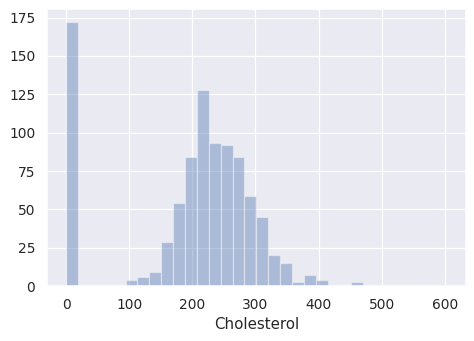

count   918.000
mean    136.809
std      25.460
min      60.000
5%       96.000
10%     103.000
20%     115.000
30%     122.000
40%     130.000
50%     138.000
60%     144.000
70%     151.000
80%     160.000
90%     170.000
95%     178.000
99%     186.000
max     202.000
Name: MaxHR, dtype: float64


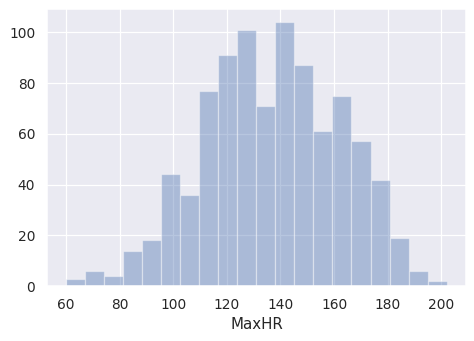

count   918.000
mean      0.887
std       1.067
min      -2.600
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%       0.600
60%       1.000
70%       1.400
80%       1.800
90%       2.300
95%       3.000
99%       4.000
max       6.200
Name: Oldpeak, dtype: float64


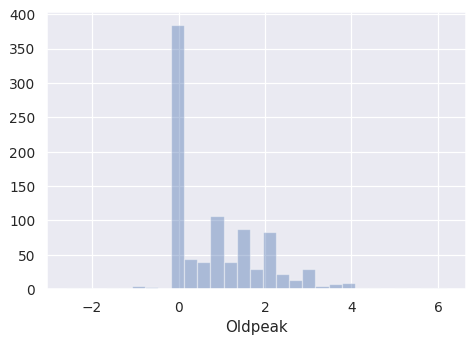

In [37]:
# We are analyzing the numeric variables.

for col in num_cols:
   num_summary(df, col, plot = True)

M    725
F    193
Name: Sex, dtype: int64


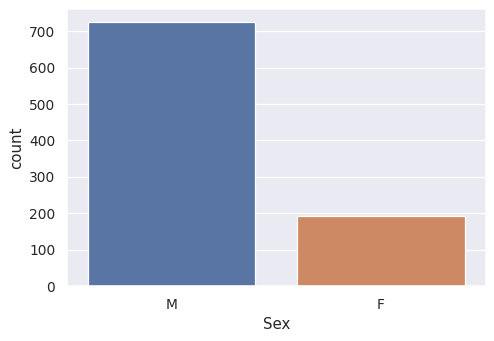

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64


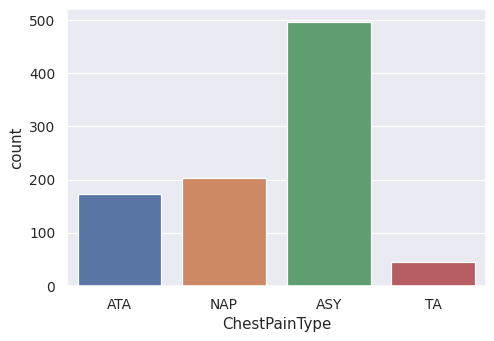

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64


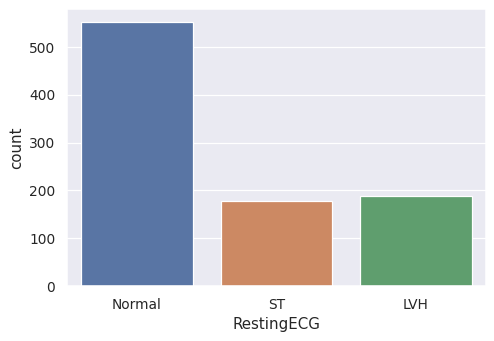

N    547
Y    371
Name: ExerciseAngina, dtype: int64


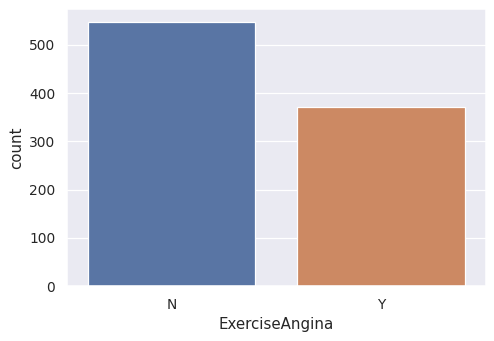

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64


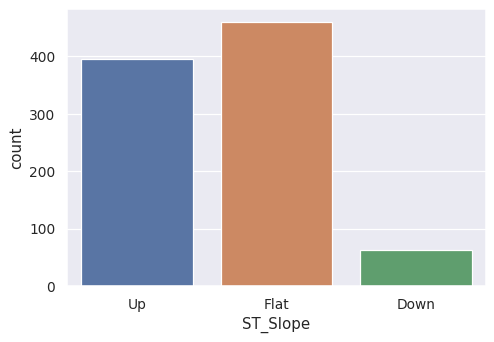

0    704
1    214
Name: FastingBS, dtype: int64


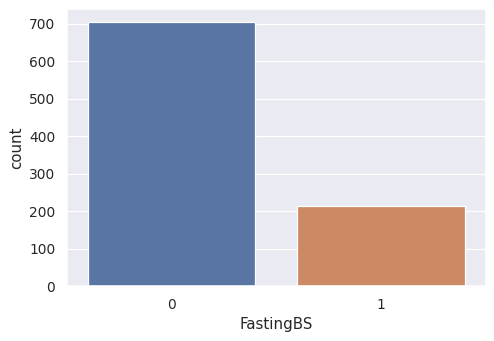

1    508
0    410
Name: HeartDisease, dtype: int64


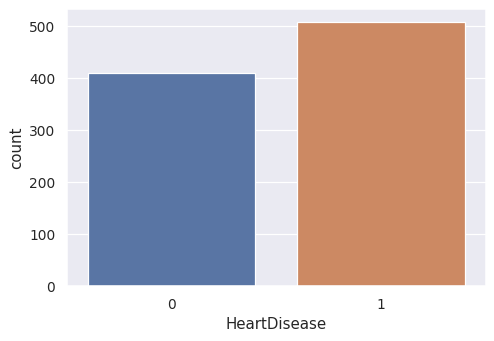

In [38]:
# We are analyzing the categorical variables.

for col in cat_cols:
    print(df[col].value_counts())
    fig = plt.subplots(figsize=(6, 4))
    sns.countplot(x = df[col], data = df)
    sns.set(rc={'figure.dpi':90})
    plt.show(block = True)

                Age
HeartDisease       
0            50.551
1            55.900


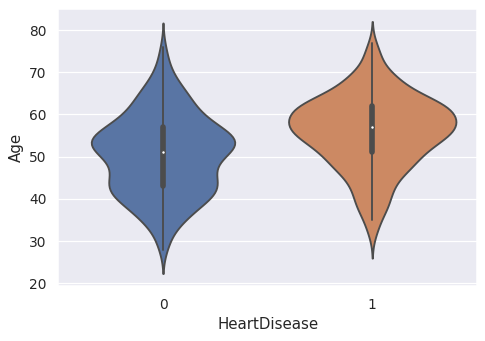

              RestingBP
HeartDisease           
0               130.180
1               134.185


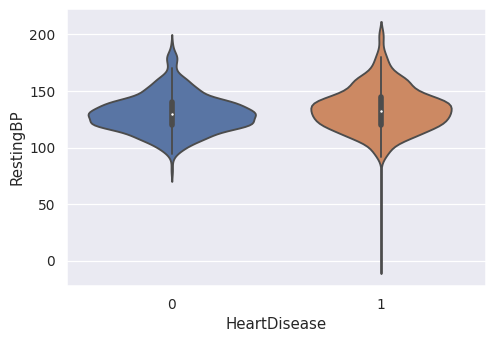

              Cholesterol
HeartDisease             
0                 227.122
1                 175.941


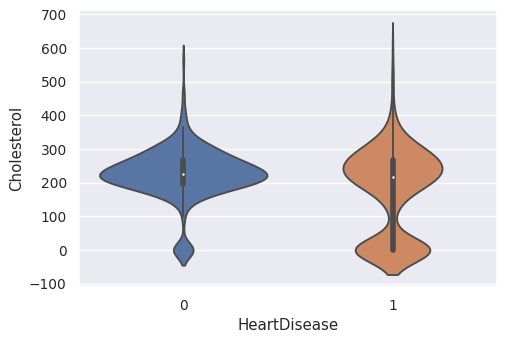

               MaxHR
HeartDisease        
0            148.151
1            127.656


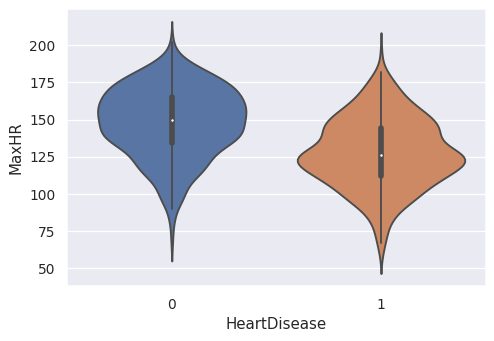

              Oldpeak
HeartDisease         
0               0.408
1               1.274


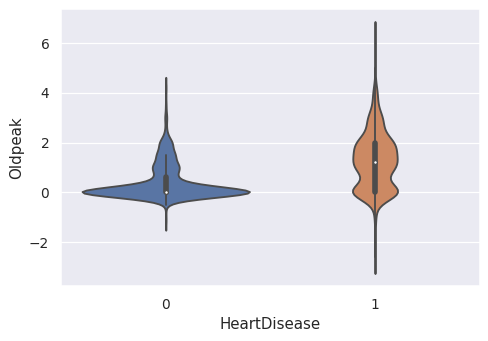

In [39]:
# We are analyzing the target variable.

for col in num_cols:
    print(df.groupby('HeartDisease').agg({col: 'mean'}))
    fig = plt.subplots(figsize=(6, 4))
    sns.violinplot(x=df["HeartDisease"], y=df[col])
    plt.show(block=True)

In [40]:
# We are analyzing the outliers.

# To detect outliers, we need to set threshold values.
def outlier_thresholds(dataframe, col_name, q1=0.04, q3=0.96):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# We are checking the variables that have outliers.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    

for col in num_cols:
    print(col, check_outlier(df, col))

Age False
RestingBP True
Cholesterol False
MaxHR False
Oldpeak False


In [41]:
# We replace the outliers with the threshold values we determined.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
    
for col in num_cols:
    replace_with_thresholds(df, col)
    
check_outlier(df, num_cols)

False

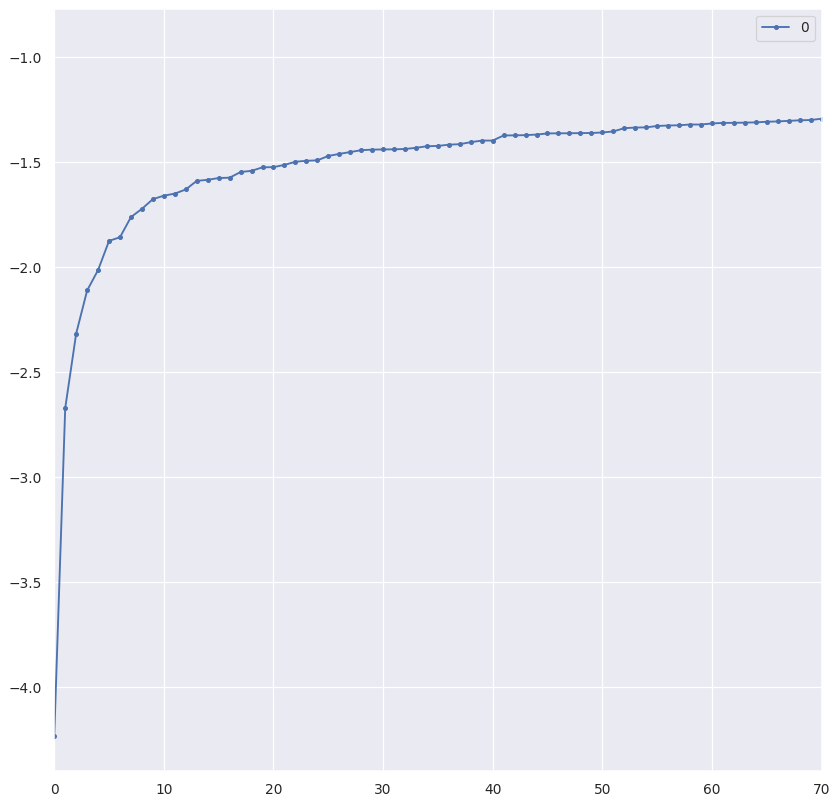

In [42]:
# We generate our scores with LOF.

df_num_cols = df[num_cols]

clf= LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df_num_cols)
df_scores = clf.negative_outlier_factor_

# We are examining the scores through a graph.
scores = pd.DataFrame(np.sort(df_scores))   
scores.plot(stacked=True, xlim=[0, 70], style='.-')
plt.show()

In [43]:
# We set the 7th point as the threshold.
th= np.sort(df_scores)[7]

# We are looking at the outlier observation units that fall below this threshold.
df[df_scores < th]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
30,53.000,M,NAP,145.000,518,0,Normal,130.000,N,0.000,Flat,1
76,32.000,M,ASY,118.000,529,0,Normal,130.000,N,0.000,Flat,1
149,54.000,M,ASY,130.000,603,1,Normal,125.000,Y,1.000,Flat,1
399,61.000,M,NAP,200.000,0,1,ST,70.000,N,0.000,Flat,1
449,55.000,M,NAP,7.500,0,0,Normal,155.000,N,1.500,Flat,1
616,67.000,F,NAP,115.000,564,0,LVH,160.000,N,1.600,Flat,0
759,54.000,M,ATA,192.000,283,0,LVH,195.000,N,0.000,Up,1


In [44]:
# We remove these outlier observations from the dataset.

df = df[~(df_scores < th)]

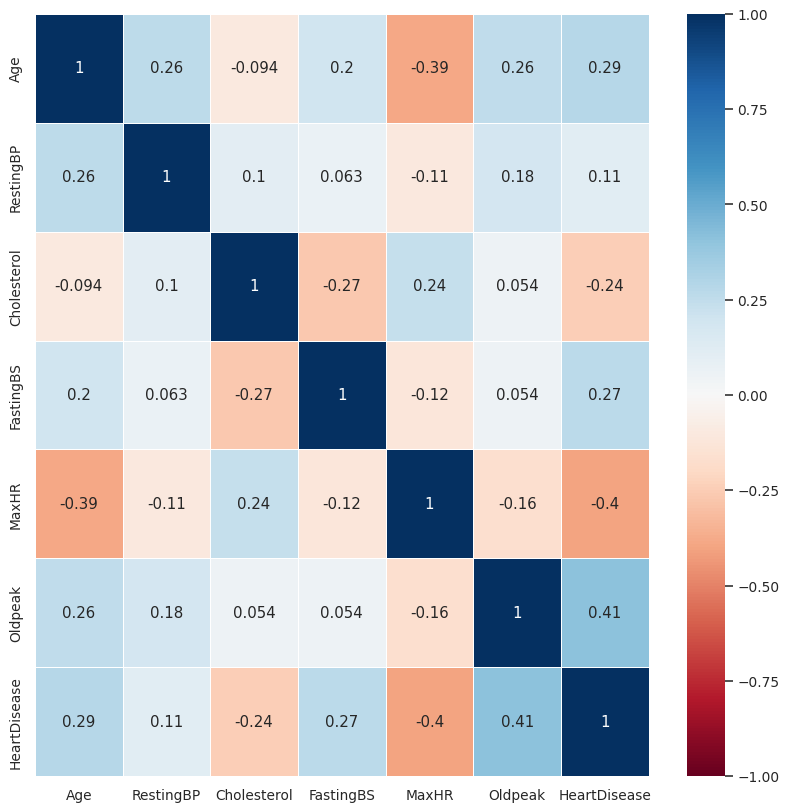

In [45]:
# We are examining our correlation analysis.

corr = df[df.columns].corr()

sns.set(rc={"figure.figsize" : (11,11)})
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax= 1 , center=0, annot=True,linewidth=.5,square=False)

plt.show()

In [46]:
# We are analyzing the missing values.

df.isnull().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,911.000,53.509,9.428,28.000,47.000,54.000,60.000,77.000
RestingBP,911.000,132.426,17.790,80.000,120.000,130.000,140.000,200.000
Cholesterol,911.000,197.586,106.784,0.000,173.500,222.000,266.000,491.000
FastingBS,911.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
MaxHR,911.000,136.801,25.365,60.000,120.000,138.000,156.000,202.000
Oldpeak,911.000,0.890,1.069,-2.600,0.000,0.600,1.500,6.200
HeartDisease,911.000,0.551,0.498,0.000,0.000,1.000,1.000,1.000


It seems no missing values.

But at first we saw that there are meaningless values.

For example: Variable such as Cholesterol cannot be 0.

We will treat these variables as NaN.

In [48]:
# We set 0 values to NaN

df["Cholesterol"] = np.where(df["Cholesterol"] == 0, np.NaN, df["Cholesterol"])
    
    
df.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       170
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

In [49]:
# We have identified missing values and we need to fill them in.
# We are implementing this using K-Nearest Neighbor (KNN) algorithm.

dff = pd.get_dummies(df, drop_first=True)

scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)

dff.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,0.245,0.500,0.502,0.000,0.789,0.295,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
1,0.429,0.667,0.234,0.000,0.676,0.409,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000
2,0.184,0.417,0.488,0.000,0.268,0.295,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
3,0.408,0.483,0.318,0.000,0.338,0.466,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000
4,0.531,0.583,0.271,0.000,0.437,0.295,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000


In [50]:
# We are filling in the variable and reversing the data back to its original state.

dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

df["Cholesterol"] = dff["Cholesterol"]

df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       7
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [51]:
df.dropna(inplace=True)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,904.000,53.502,9.430,28.000,47.000,54.000,60.000,77.000
RestingBP,904.000,132.394,17.805,80.000,120.000,130.000,140.000,200.000
Cholesterol,904.000,242.660,50.420,85.000,211.000,237.100,271.000,491.000
FastingBS,904.000,0.232,0.423,0.000,0.000,0.000,0.000,1.000
MaxHR,904.000,136.812,25.341,60.000,120.000,138.000,156.000,202.000
Oldpeak,904.000,0.889,1.068,-2.600,0.000,0.600,1.500,6.200
HeartDisease,904.000,0.549,0.498,0.000,0.000,1.000,1.000,1.000


In [52]:
# Now we are creating new variables.

df.loc[(df['Oldpeak'] <= 0) & (df['FastingBS'] == 0), 'NEW_PEAK_FAST'] = 'peak<bs0'

df.loc[(df['Oldpeak'] <= 0) & (df['FastingBS'] == 1), 'NEW_PEAK_FAST'] = 'peak<bs1'

df.loc[(df['Oldpeak'] > 0) & (df['Oldpeak'] < 2) & (df['FastingBS'] == 0), 'NEW_PEAK_FAST'] = 'peak--bs0'

df.loc[(df['Oldpeak'] > 0) & (df['Oldpeak'] < 2) & (df['FastingBS'] == 1), 'NEW_PEAK_FAST'] = 'peak--bs1'

df.loc[(df['Oldpeak'] >= 2) & (df['FastingBS'] == 0), 'NEW_PEAK_FAST'] = 'peak>bs0'

df.loc[(df['Oldpeak'] >= 2) & (df['FastingBS'] == 1), 'NEW_PEAK_FAST'] = 'peak>bs1'


In [53]:
# Now we are creating new variables.

def calculate_peak_bshr(row):
    if row['Oldpeak'] < 0:
        return ((row['FastingBS'] + 1) * 100 / row['MaxHR']) * 1.5
    elif row['Oldpeak'] < 2:
        return (row['FastingBS'] + 1) * 100 / row['MaxHR']
    else:
        return ((row['FastingBS'] + 1) * 100 / row['MaxHR']) * 2
    

df['peak_bshr'] = df.apply(calculate_peak_bshr, axis=1)



In [54]:
# Now we are creating new variables.

df["AGE_CHOL"] = df["Age"] / df["Cholesterol"]

In [55]:
# Now we are creating new variables.

df.loc[(df['ST_Slope'] == "Up") & (df['ExerciseAngina'] == "N"), 'NEW_ST_EXAN'] = 'stupexan-'

df.loc[(df['ST_Slope'] == "Up") & (df['ExerciseAngina'] == "Y"), 'NEW_ST_EXAN'] = 'stupexan+'

df.loc[(df['ST_Slope'] == "Down") & (df['ExerciseAngina'] == "N"), 'NEW_ST_EXAN'] = 'stdownexan-'

df.loc[(df['ST_Slope'] == "Down") & (df['ExerciseAngina'] == "Y"), 'NEW_ST_EXAN'] = 'stdownexan+'

df.loc[(df['ST_Slope'] == "Flat") & (df['ExerciseAngina'] == "N"), 'NEW_ST_EXAN'] = 'stflatexan-'

df.loc[(df['ST_Slope'] == "Flat") & (df['ExerciseAngina'] == "Y"), 'NEW_ST_EXAN'] = 'stflatexan+'


In [56]:
# Now we are creating new variables.

def calculate_pain_age_hr(row):
    if row['ChestPainType'] == "ATA":
        return row['Age'] * 12 / row['MaxHR'] 
    elif row['ChestPainType'] == "NAP":
        return row['Age'] * 14 / row['MaxHR']
    elif row['ChestPainType'] == "TA":
        return row['Age'] * 16 / row['MaxHR']
    else:
        return row['Age'] * 18 / row['MaxHR']
    

df['pain_age_hrr'] = df.apply(calculate_pain_age_hr, axis=1)

In [57]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,NEW_PEAK_FAST,peak_bshr,AGE_CHOL,NEW_ST_EXAN,pain_age_hrr
0,40.000,M,ATA,140.000,289.000,0,Normal,172.000,N,0.000,Up,0,peak<bs0,0.581,0.138,stupexan-,2.791
1,49.000,F,NAP,160.000,180.000,0,Normal,156.000,N,1.000,Flat,1,peak--bs0,0.641,0.272,stflatexan-,4.397
2,37.000,M,ATA,130.000,283.000,0,ST,98.000,N,0.000,Up,0,peak<bs0,1.020,0.131,stupexan-,4.531
3,48.000,F,ASY,138.000,214.000,0,Normal,108.000,Y,1.500,Flat,1,peak--bs0,0.926,0.224,stflatexan+,8.000
4,54.000,M,NAP,150.000,195.000,0,Normal,122.000,N,0.000,Up,0,peak<bs0,0.820,0.277,stupexan-,6.197


In [58]:
# We are performing the encoding process.

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() >= 2]

ohe_cols = [col for col in ohe_cols if col not in "HeartDisease"]

df= one_hot_encoder(df, ohe_cols)

df.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,peak_bshr,AGE_CHOL,pain_age_hrr,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,NEW_PEAK_FAST_peak--bs1,NEW_PEAK_FAST_peak<bs0,NEW_PEAK_FAST_peak<bs1,NEW_PEAK_FAST_peak>bs0,NEW_PEAK_FAST_peak>bs1,NEW_ST_EXAN_stdownexan-,NEW_ST_EXAN_stflatexan+,NEW_ST_EXAN_stflatexan-,NEW_ST_EXAN_stupexan+,NEW_ST_EXAN_stupexan-
0,40.000,140.000,289.000,172.000,0.000,0,0.581,0.138,2.791,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,49.000,160.000,180.000,156.000,1.000,1,0.641,0.272,4.397,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,37.000,130.000,283.000,98.000,0.000,0,1.020,0.131,4.531,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
3,48.000,138.000,214.000,108.000,1.500,1,0.926,0.224,8.000,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0
4,54.000,150.000,195.000,122.000,0.000,0,0.820,0.277,6.197,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1


In [59]:
# We are performing standardization processes.

cat_cols, num_cols, cat_but_car = grab_col_names(df)

mms = MinMaxScaler()    
df[num_cols] = mms.fit_transform(df[num_cols])

df.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,peak_bshr,AGE_CHOL,pain_age_hrr,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,NEW_PEAK_FAST_peak--bs1,NEW_PEAK_FAST_peak<bs0,NEW_PEAK_FAST_peak<bs1,NEW_PEAK_FAST_peak>bs0,NEW_PEAK_FAST_peak>bs1,NEW_ST_EXAN_stdownexan-,NEW_ST_EXAN_stflatexan+,NEW_ST_EXAN_stflatexan-,NEW_ST_EXAN_stupexan+,NEW_ST_EXAN_stupexan-
0,0.245,0.500,0.502,0.789,0.295,0,0.018,0.119,0.068,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,0.429,0.667,0.234,0.676,0.409,1,0.031,0.406,0.170,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0.184,0.417,0.488,0.268,0.295,0,0.112,0.102,0.178,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
3,0.408,0.483,0.318,0.338,0.466,1,0.092,0.303,0.399,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0
4,0.531,0.583,0.271,0.437,0.295,0,0.069,0.416,0.284,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1


In [60]:
# We are applying our machine learning model.( Logistic Regression)

y = df["HeartDisease"]   

X = df.drop(["HeartDisease"], axis=1)   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state=25)

log_model = LogisticRegression().fit(X_train, y_train) 

y_pred = log_model.predict(X_test)   
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       157
           1       0.88      0.89      0.89       205

    accuracy                           0.87       362
   macro avg       0.87      0.87      0.87       362
weighted avg       0.87      0.87      0.87       362



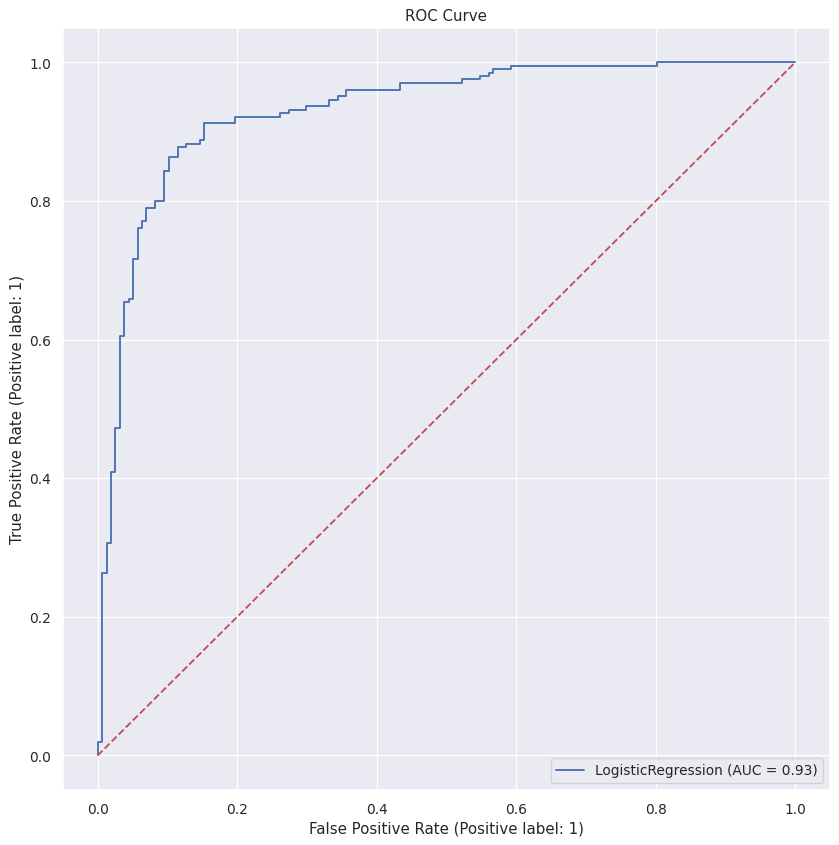

In [61]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [62]:
roc_auc_score(y_test, y_prob)

0.9306819947180364

In [63]:
# K-Fold Cross Validation

y = df["HeartDisease"]   

X = df.drop(["HeartDisease"], axis=1)   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

log_model = LogisticRegression().fit(X_train, y_train)

cv_results = cross_validate(log_model,    
                            X, y,         
                            cv=17,        
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])


print(cv_results['test_accuracy'].mean(),
      cv_results['test_precision'].mean(),
      cv_results['test_recall'].mean(),
      cv_results['test_f1'].mean(),
      cv_results['test_roc_auc'].mean())


0.8527150902289637 0.8642737933589892 0.8789722785665991 0.866014044101505 0.9233040342573812
